In [1]:
import os
from functools import partial
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

import pyro
import pyro.distributions as dist

# for CI testing
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.5.1')
pyro.enable_validation(True)
pyro.set_rng_seed(1)
pyro.enable_validation(True)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

from pyro.nn import PyroSample
from pyro.nn import PyroModule
from torch import nn
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.infer import Predictive

import raw_dataloader
import preprocessing
import bandpower

import warnings
warnings.filterwarnings('ignore')

## Import data

In [2]:
X,Y,_,S,D = raw_dataloader.read_data([1,2,3], range(11), channel_limit=21, rm_baseline=True)
low, high = [4,7,13], [7,13,30]    # theta, alpha, beta
X = bandpower.get_bandpower(X, low=low, high=high)
X = X.reshape((X.shape[0],-1))
num_feature = X.shape[1]

After removing trials longer than 60s, X shape:  (1039, 21, 512)
Arrange all the channels as the same order

Calculating the bandpower of time-series data...


In [3]:
# numpy array -> torch tensor
tensor_X = torch.from_numpy(X).float()
tensor_Y = torch.from_numpy(Y).float()

# Seperate data through subjects
dict_X = {i_sub : tensor_X[S==i_sub,:] for i_sub in np.unique(S)}
dict_Y = {i_sub : tensor_Y[S==i_sub]   for i_sub in np.unique(S)}

## Pyro Bayesian Regression

In [4]:
class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean
    
def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

[iteration 0001] loss: 12.9018
[iteration 0101] loss: 5.6990
[iteration 0201] loss: 5.2873
[iteration 0301] loss: 4.9332
[iteration 0401] loss: 5.1440
[iteration 0501] loss: 5.5856
[iteration 0601] loss: 5.2247
[iteration 0701] loss: 5.4388
[iteration 0801] loss: 5.2435
[iteration 0901] loss: 11.6944
[iteration 1001] loss: 4.8463
[iteration 1101] loss: 6.0633
[iteration 1201] loss: 5.0494
[iteration 1301] loss: 5.3809
[iteration 1401] loss: 4.8125
[iteration 0001] loss: 15.1759
[iteration 0101] loss: 5.6251
[iteration 0201] loss: 5.1001
[iteration 0301] loss: 4.9341
[iteration 0401] loss: 4.7543
[iteration 0501] loss: 5.2837
[iteration 0601] loss: 4.8302
[iteration 0701] loss: 4.5236
[iteration 0801] loss: 4.8159
[iteration 0901] loss: 4.8972
[iteration 1001] loss: 4.6138
[iteration 1101] loss: 4.9496
[iteration 1201] loss: 4.7325
[iteration 1301] loss: 4.8670
[iteration 1401] loss: 6.0854
[iteration 0001] loss: 4.8581
[iteration 0101] loss: 4.3152
[iteration 0201] loss: 3.9596
[iterat

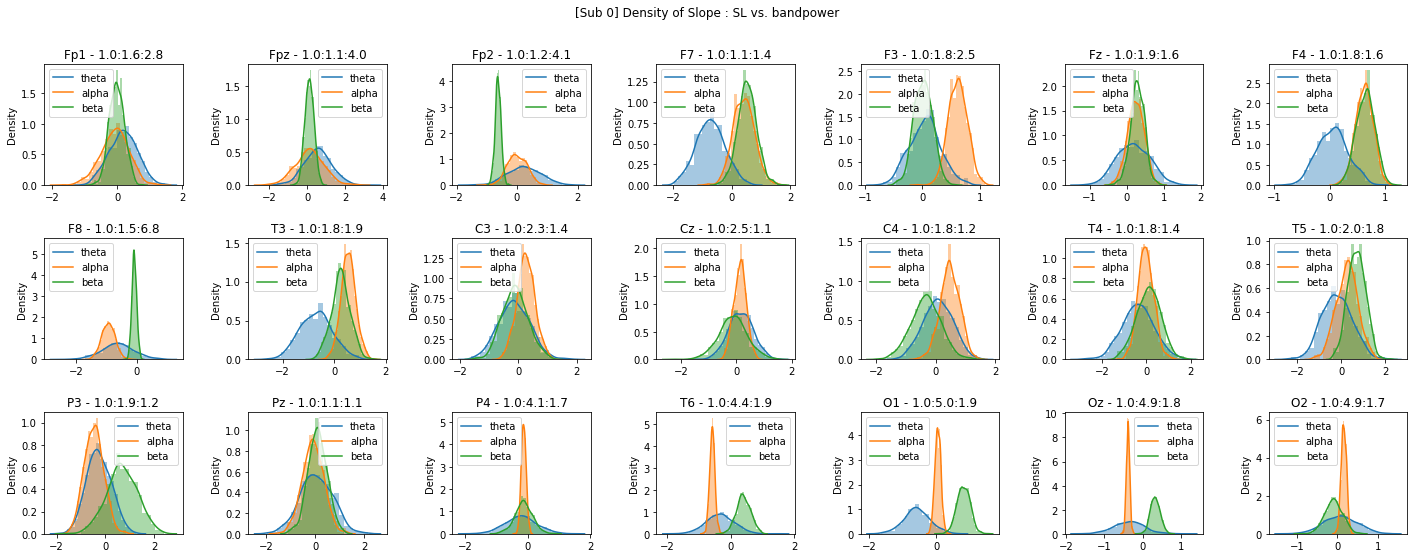

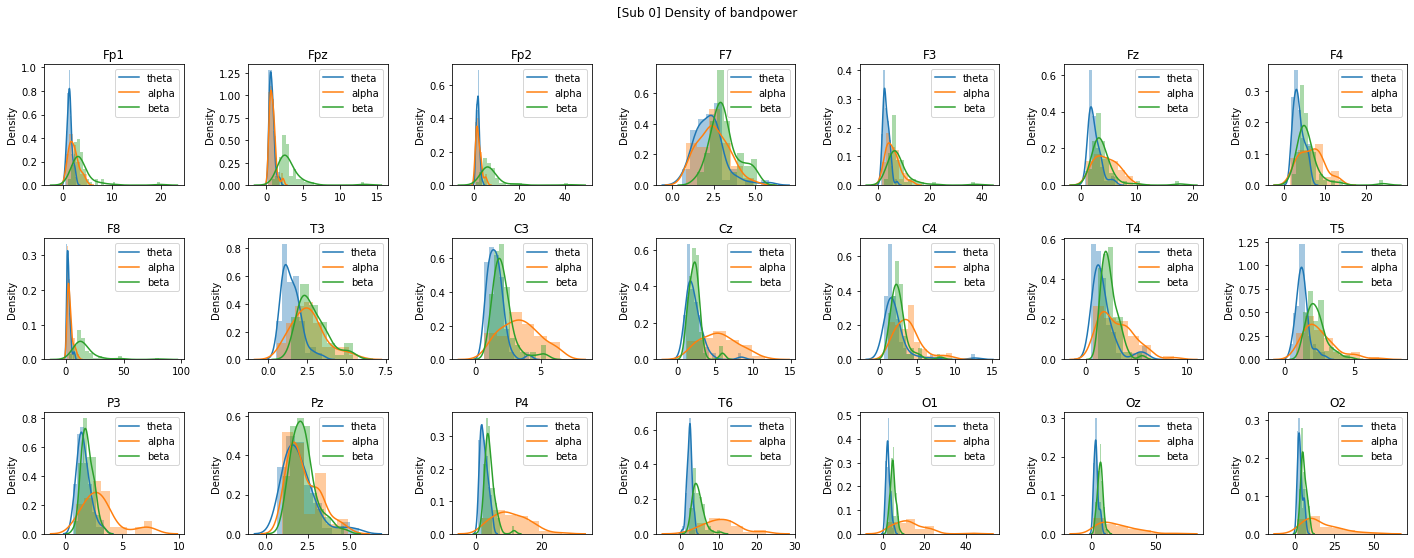

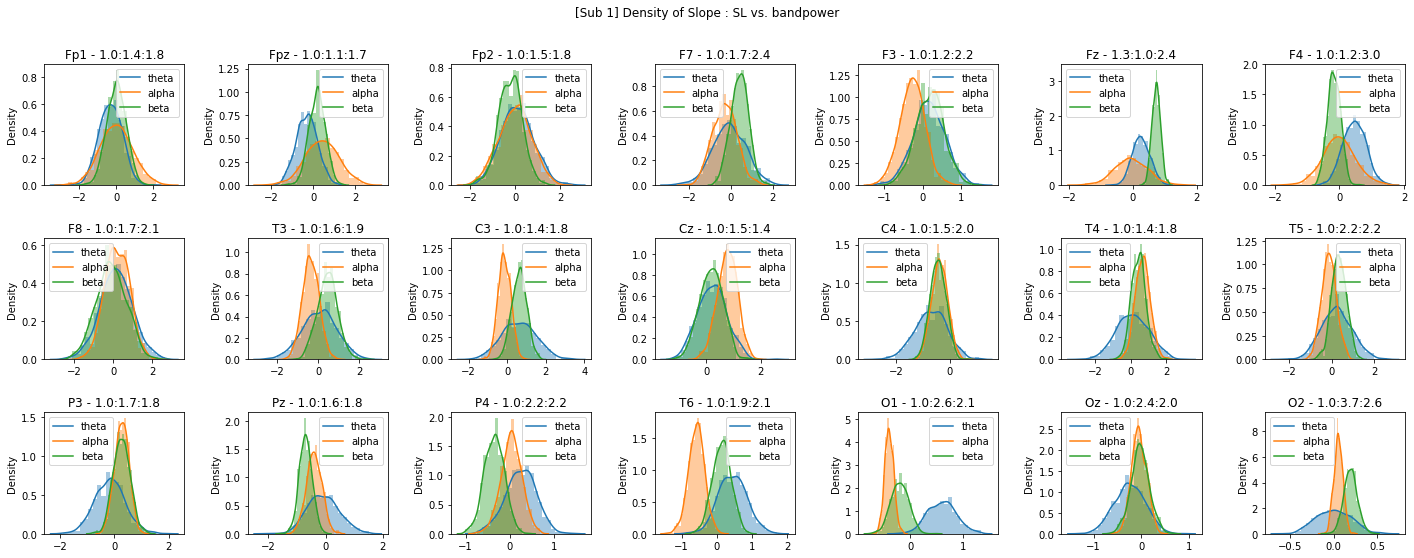

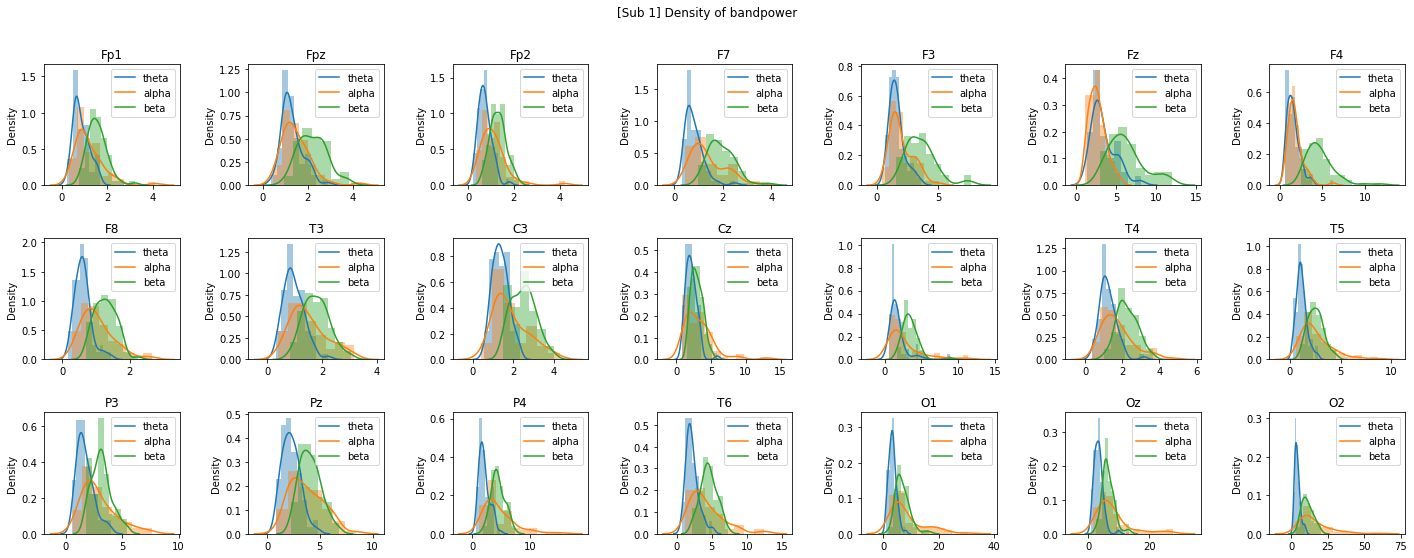

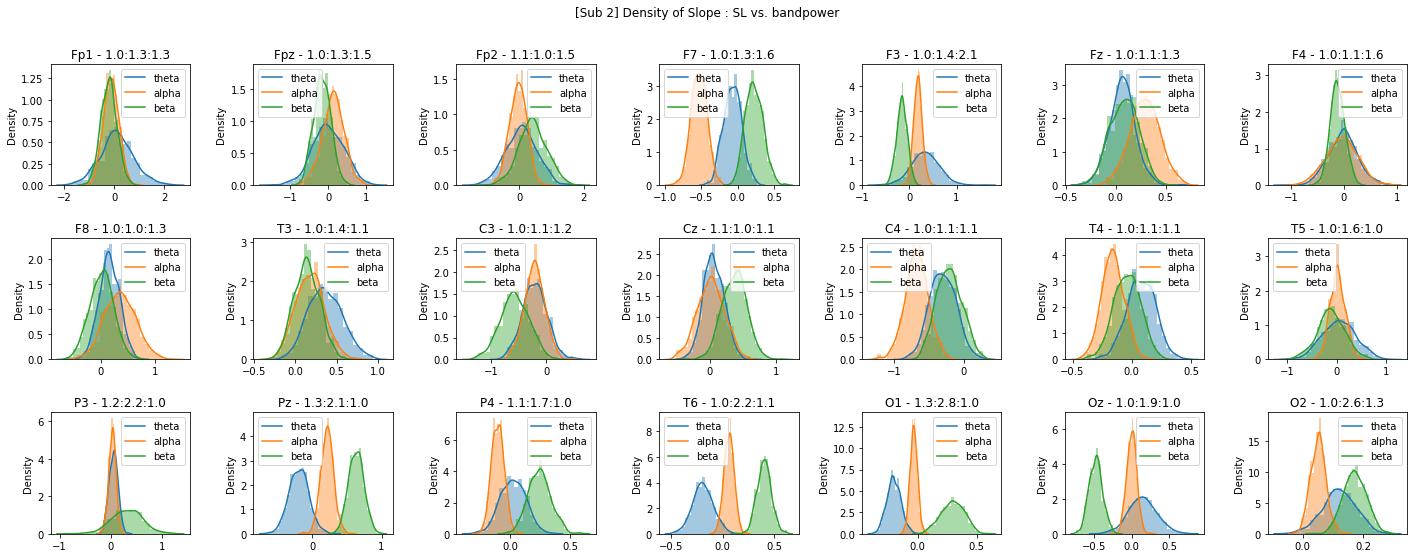

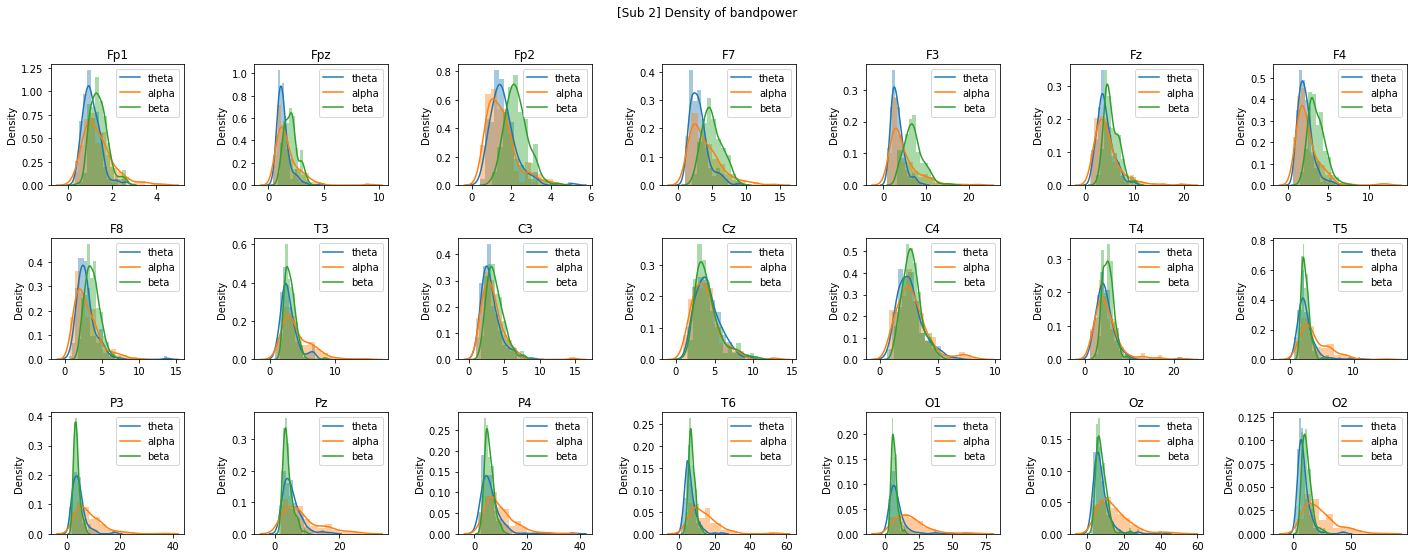

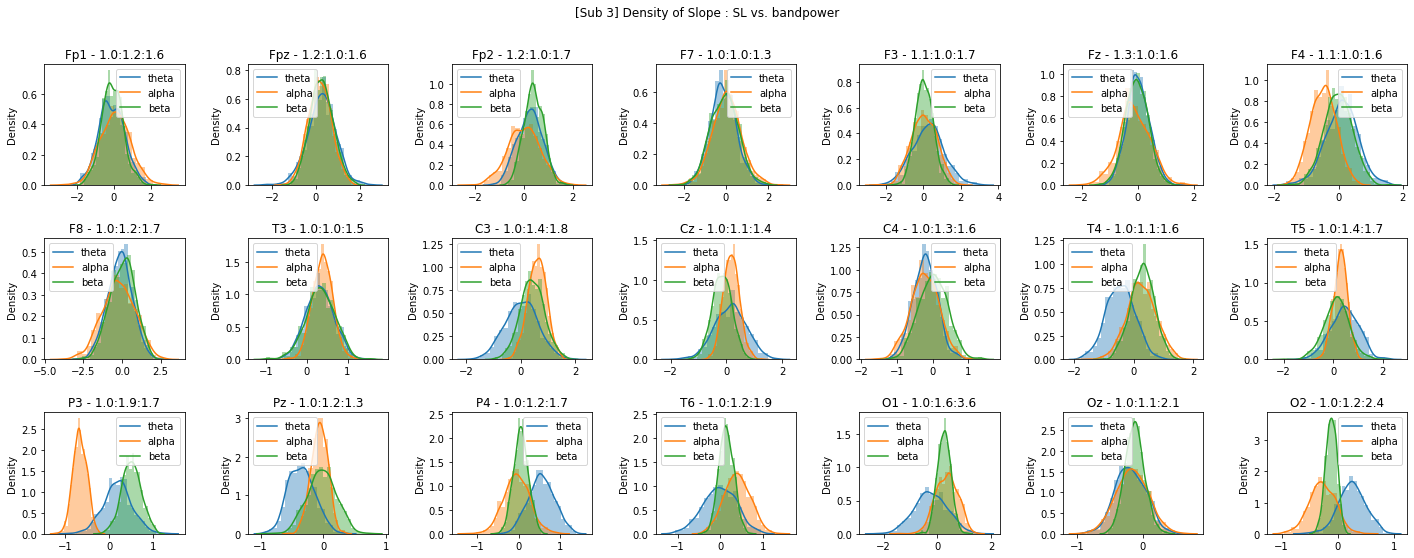

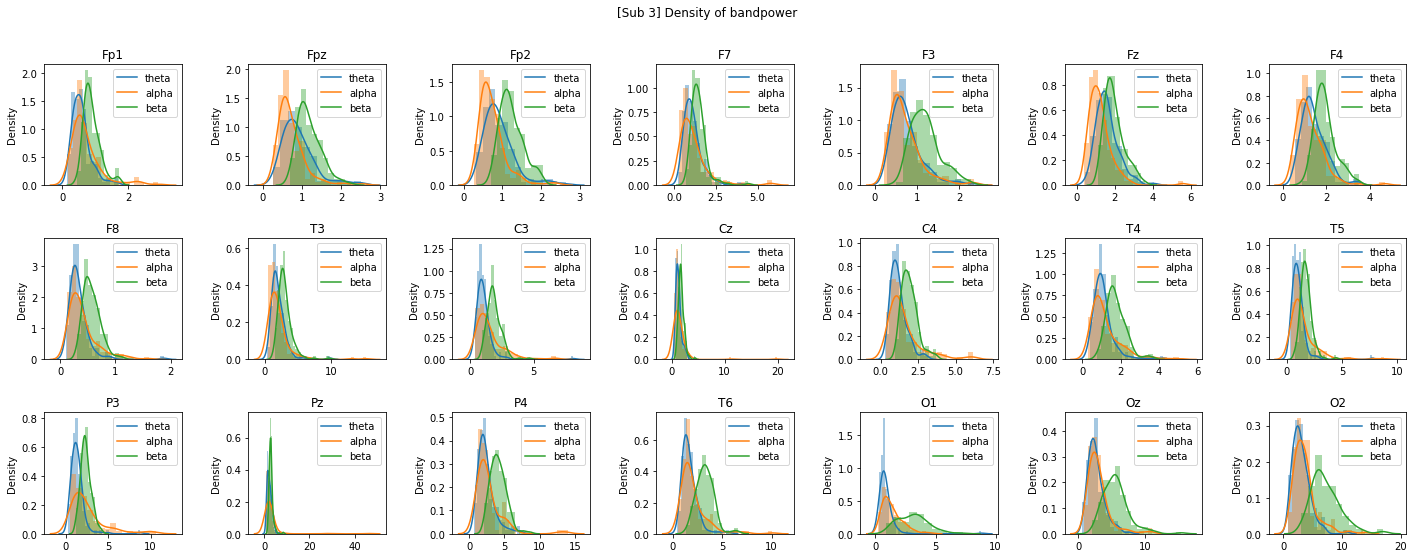

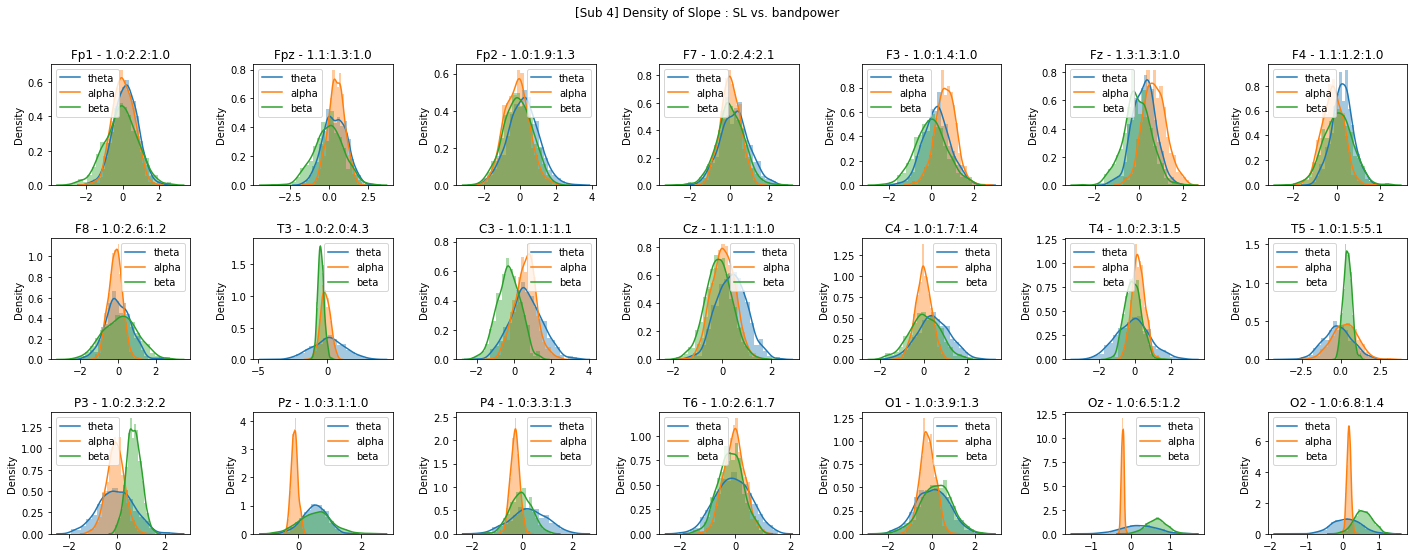

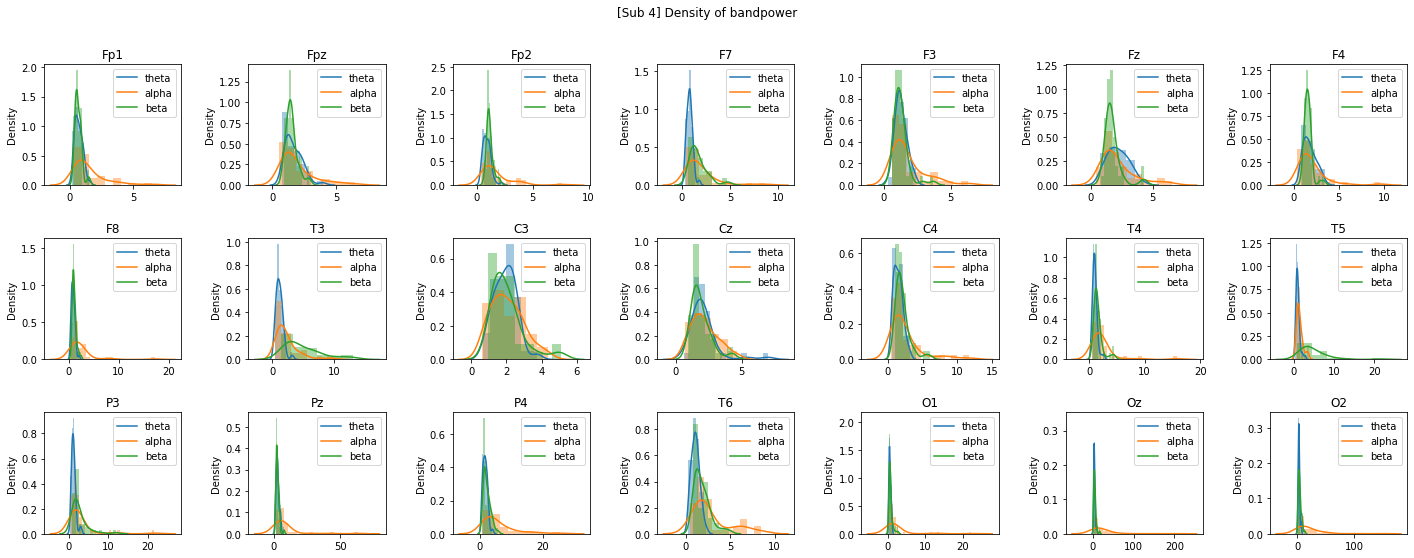

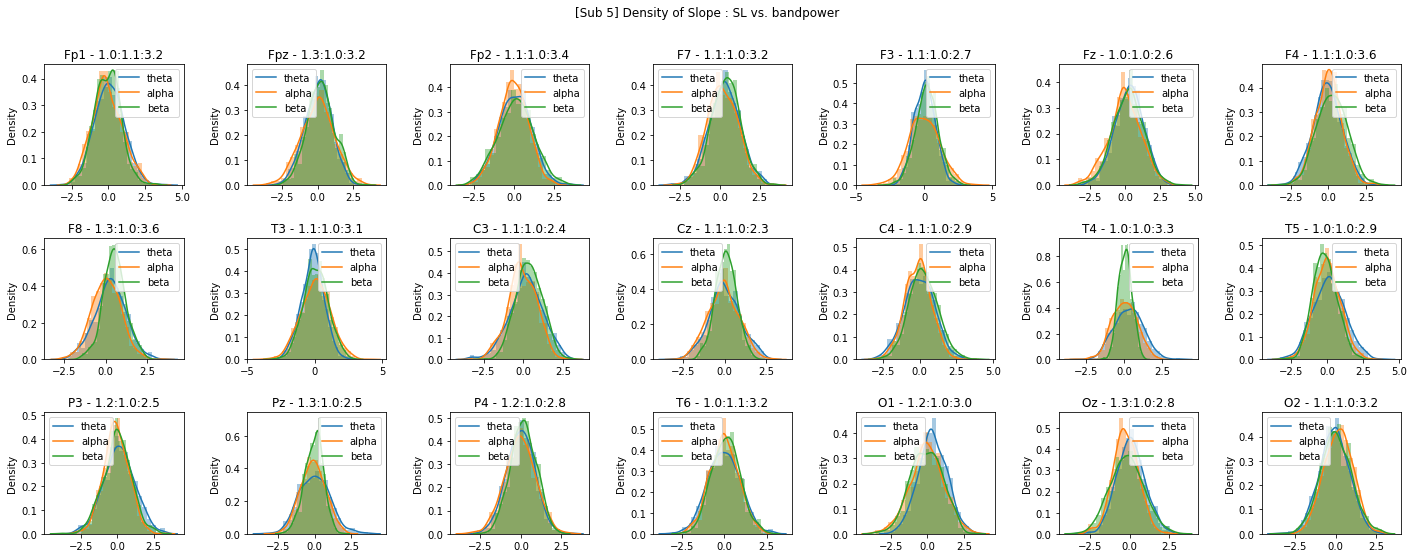

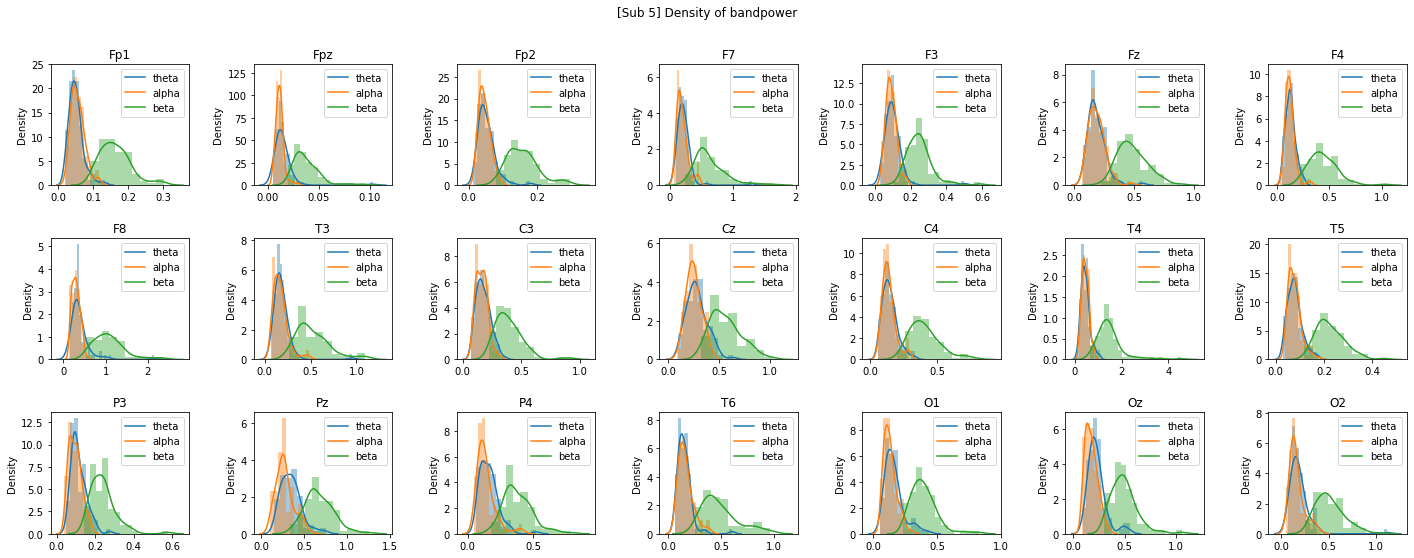

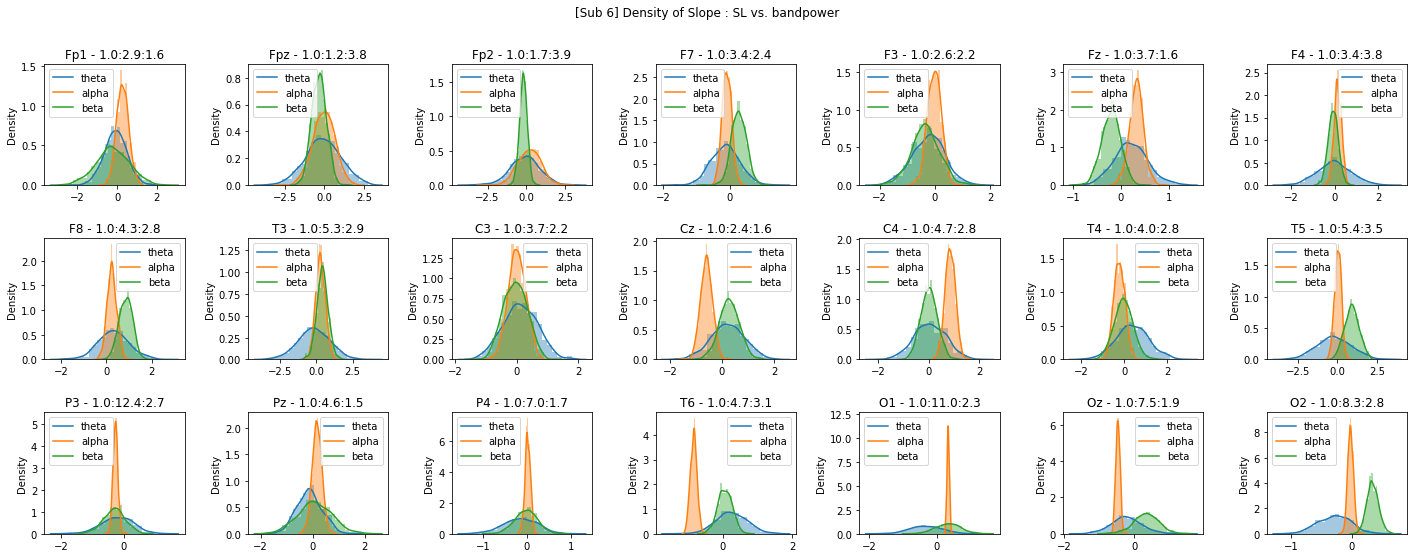

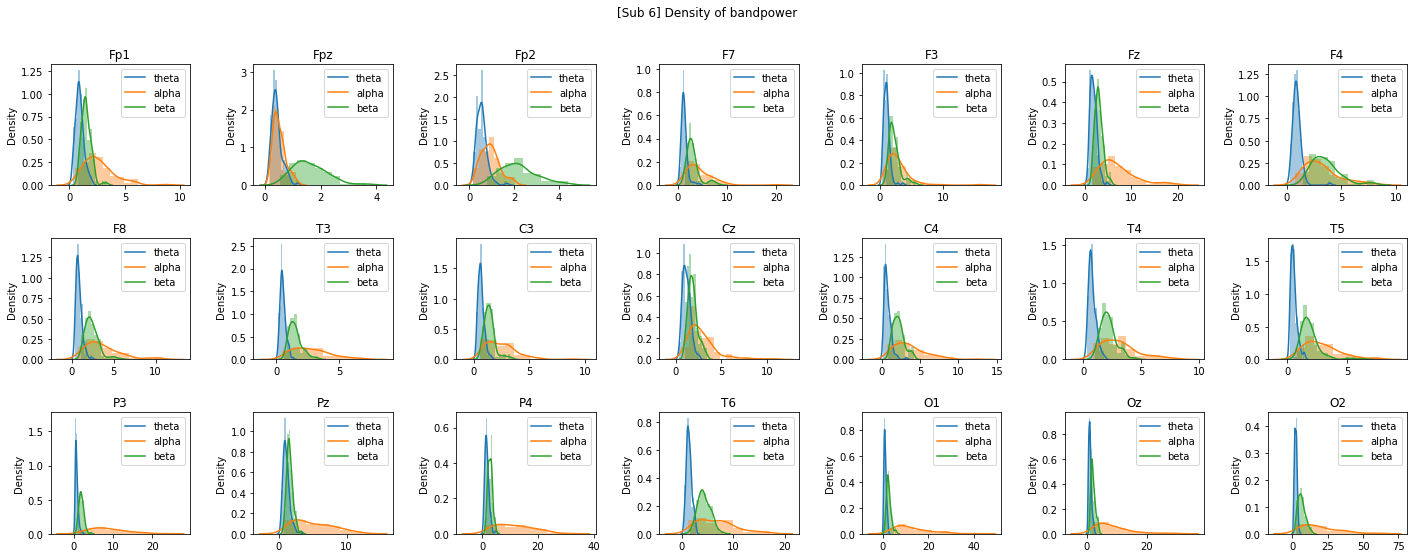

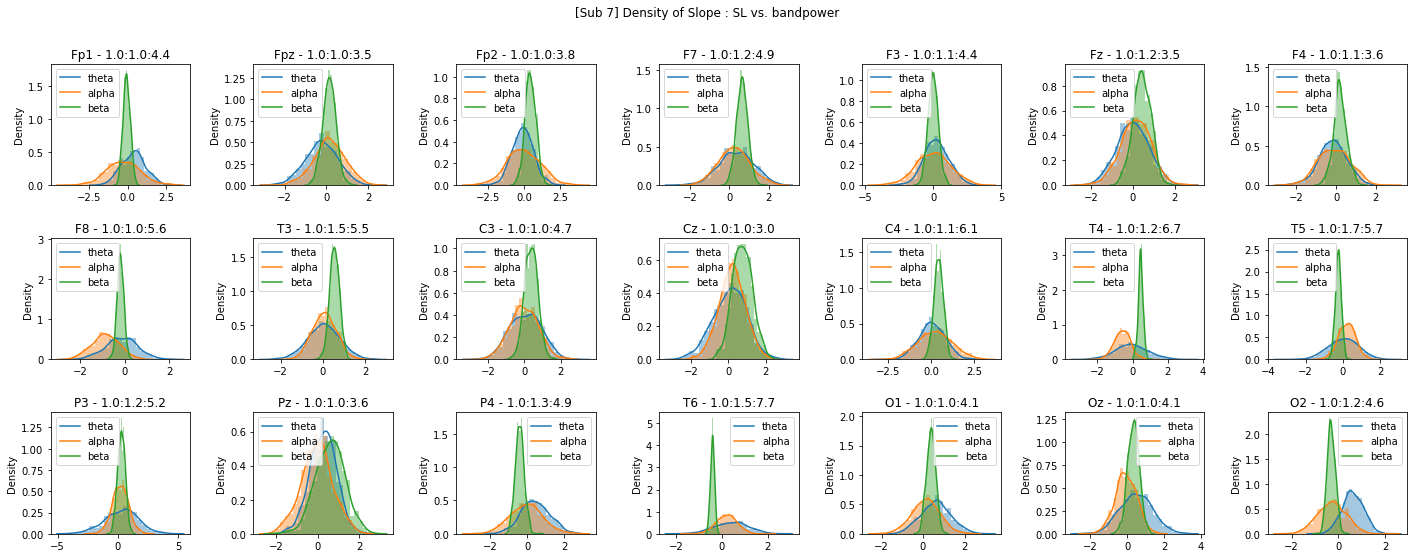

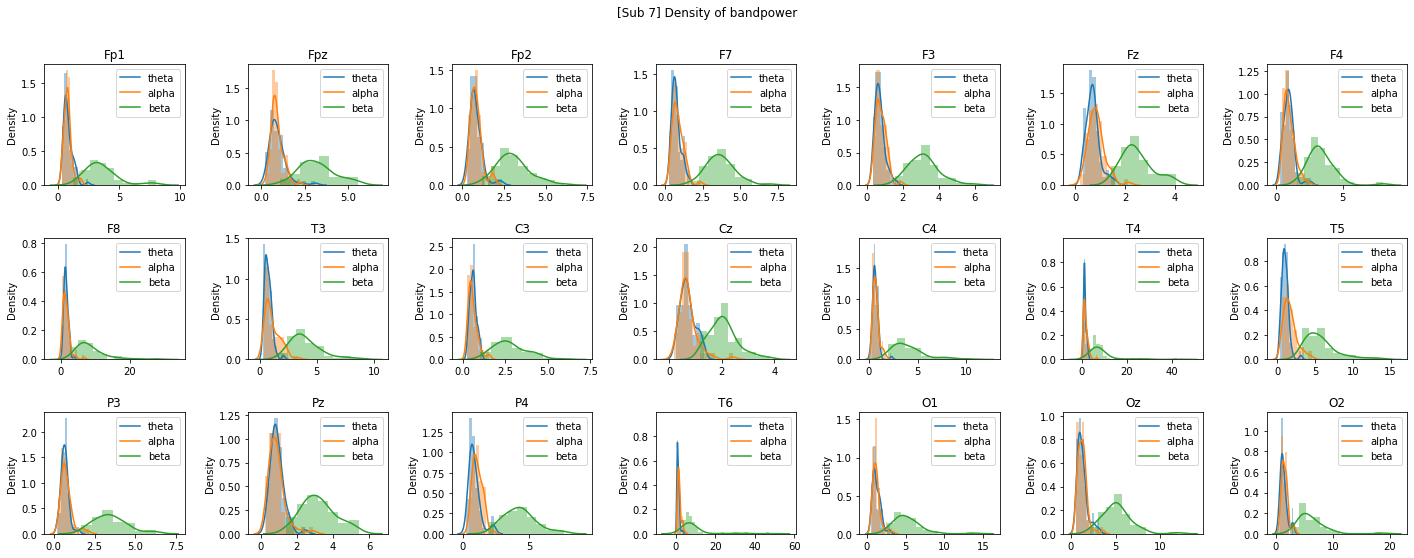

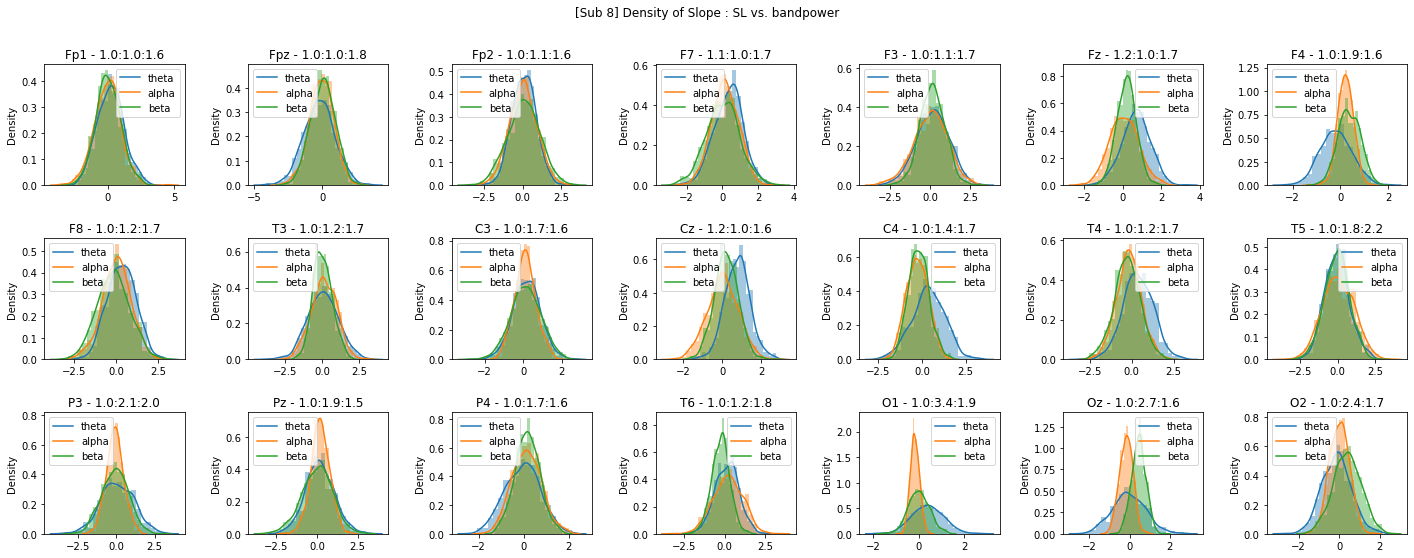

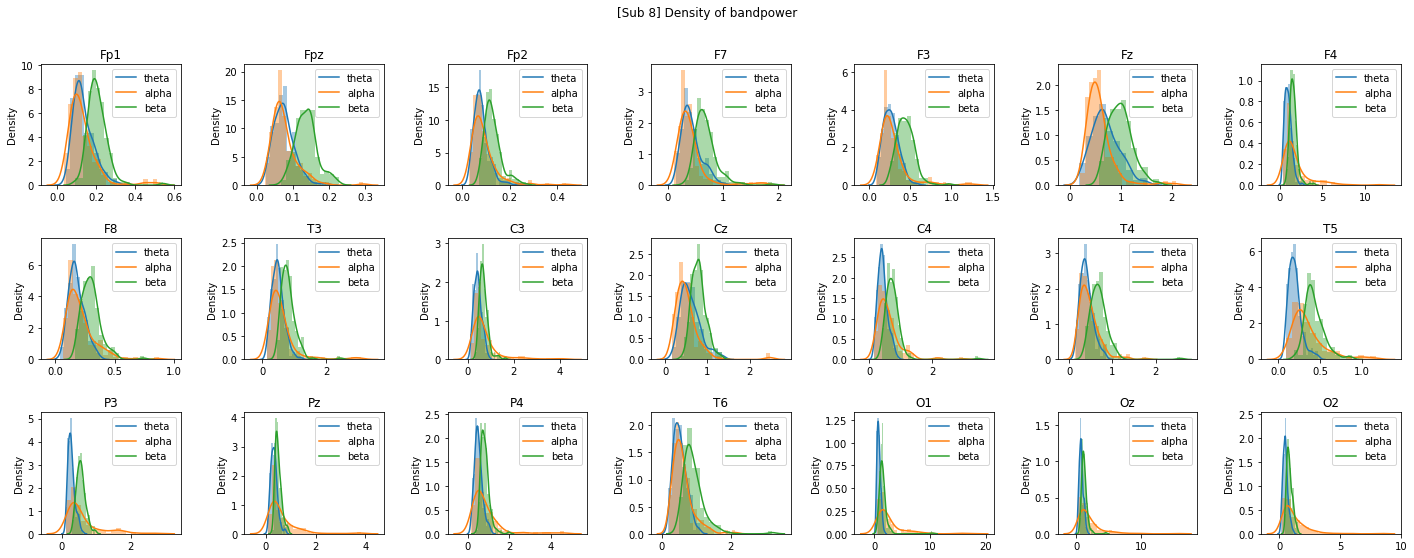

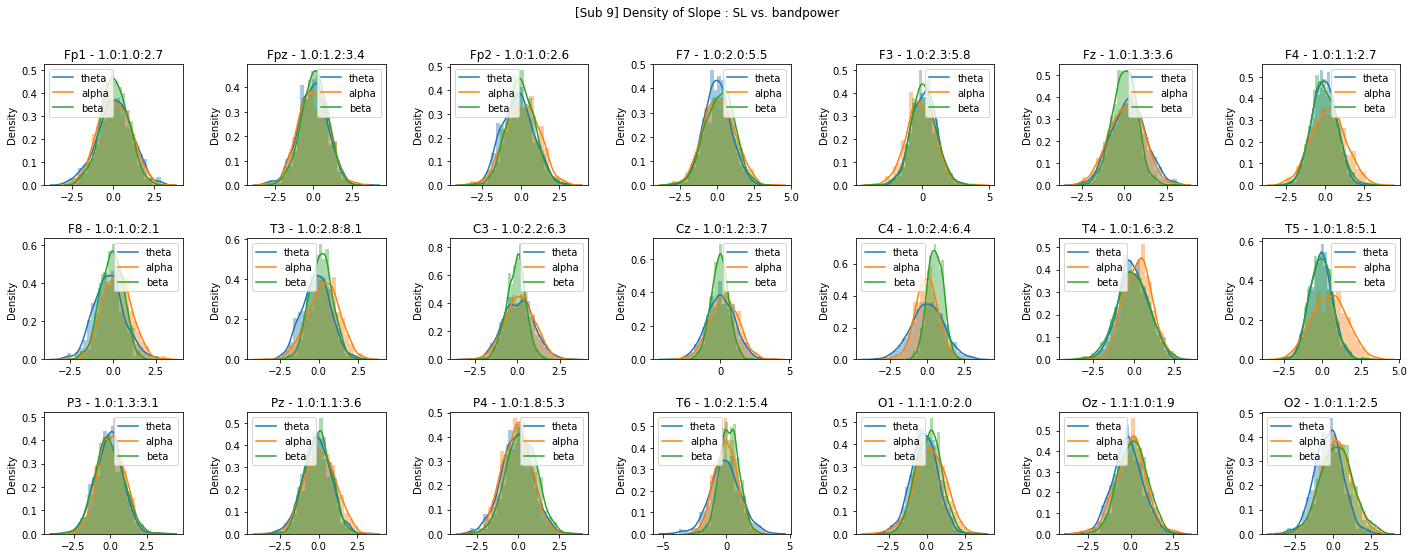

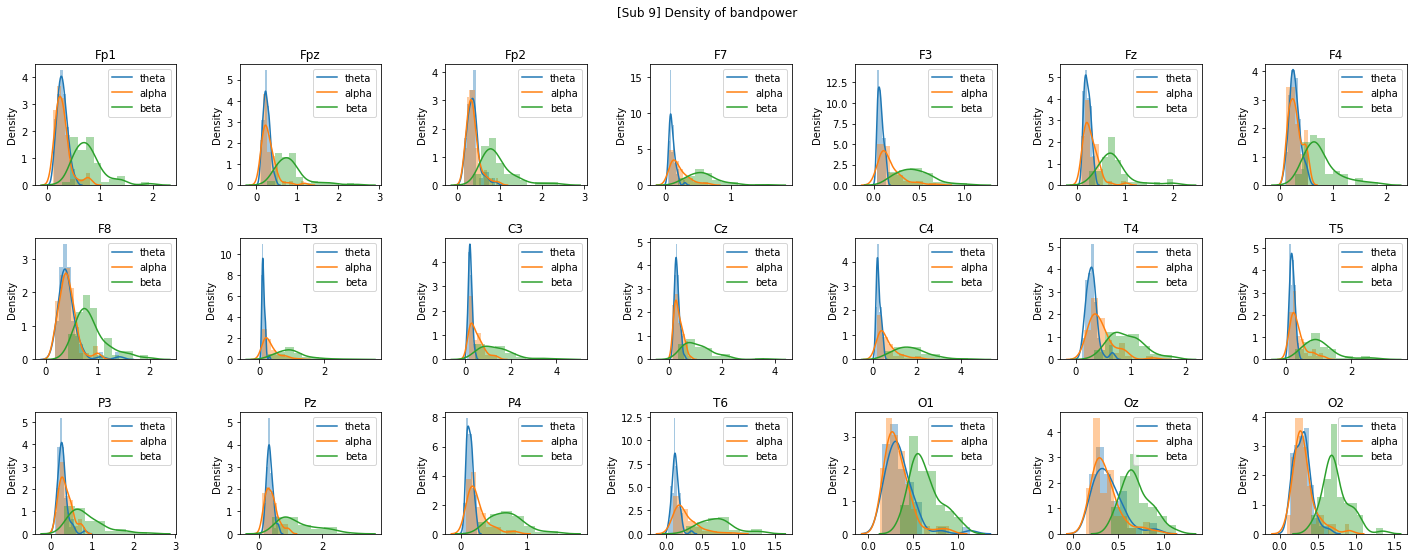

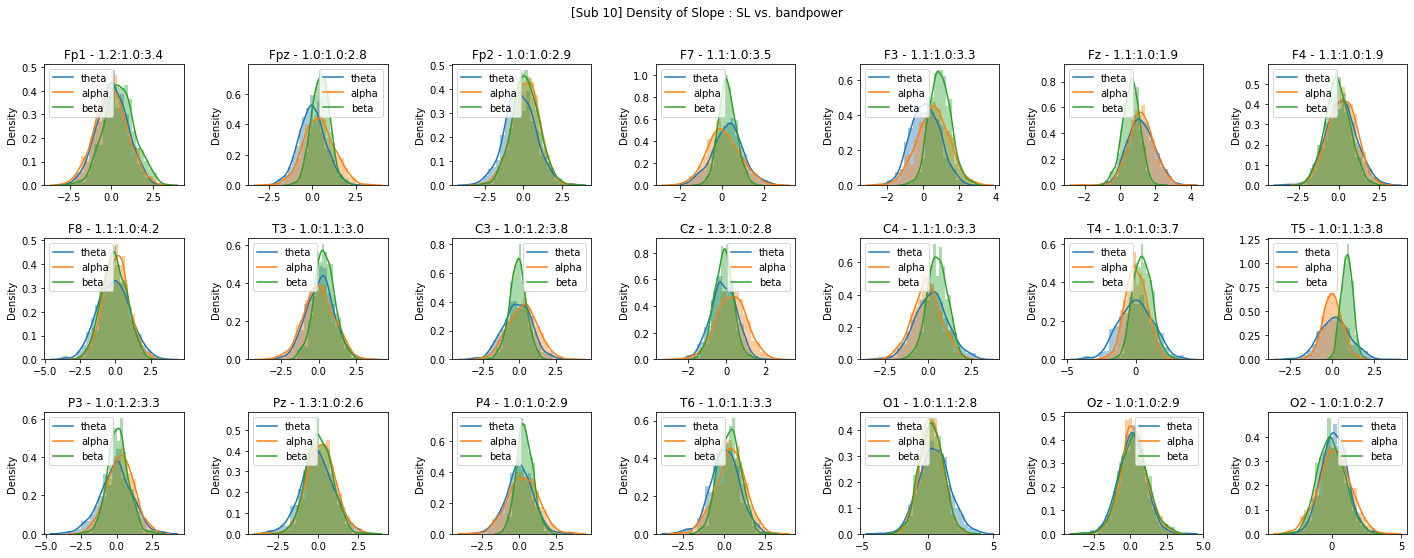

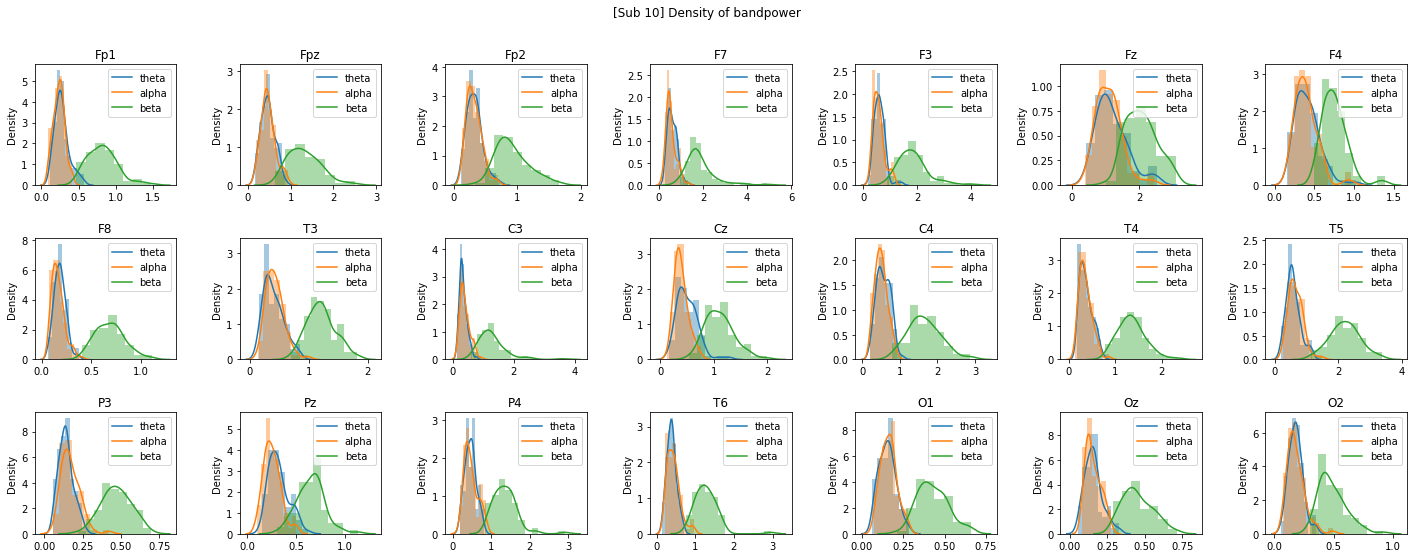

In [5]:
num_iterations = 1500 if not smoke_test else 2
loss_all = np.zeros((11,num_iterations))
bp_ratio = torch.zeros(11, 21, 3) # (sub, channel, band)
weight_list = []   # Store dict weight

for i_sub in range(11):
    model = BayesianRegression(X.shape[1], 1)
    guide = AutoDiagonalNormal(model)
    adam = pyro.optim.Adam({"lr": 0.03})
    svi = SVI(model, guide, adam, loss=Trace_ELBO())

    # Train the model
    pyro.clear_param_store()
    x_data, y_data = dict_X[i_sub], dict_Y[i_sub]
    for j in range(num_iterations):
        # calculate the loss and take a gradient step
        loss = svi.step(x_data, y_data)
        loss_all[i_sub,j] = loss/len(x_data)
        if j % 100 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(x_data)))
            
    # Evaluate the model
    guide.requires_grad_(False)
    predictive = Predictive(model, guide=guide, num_samples=800,
                            return_sites=("linear.weight", "obs", "_RETURN"))
    samples = predictive(x_data)
    pred_summary = summary(samples)
    
    # Plot density plot of slope: SL vs. ERSP
    weight = samples["linear.weight"]
    weight = weight.reshape(weight.shape[0], num_feature)

    # feature: channel * band
    channels = pd.read_csv('./Channel_coordinate/Channel_location_angle_21.csv')['Channel']
    dict_weight = {channels[i]: weight[:, i*3:(i+1)*3] for i in range(21)}
    weight_list.append(dict_weight)
    x_data = torch.reshape(x_data, (x_data.shape[0], num_feature//3, 3)) # channel*band -> (channel, band)

    # Plot density of weight
    fig, axs = plt.subplots(3,7, figsize=(20,8))

    for i in range(21):
        # Calculate bandpower ratio
        for i_band in range(3):
            bp_ratio[i_sub, i, i_band] = torch.mean(x_data[:, i, i_band])
        bp_ratio[i_sub, i, :] /= torch.min(bp_ratio[i_sub, i, :])
            
        row = i//7
        col = i%7

        for i_band, band in enumerate(['theta', 'alpha', 'beta']):
            sns.distplot(dict_weight[channels[i]][:,i_band], kde_kws={'label': band}, ax=axs[row,col])

        axs[row,col].set_title('%s - %.1f:%.1f:%.1f'%(channels[i], bp_ratio[i_sub,i,0], bp_ratio[i_sub,i,1], bp_ratio[i_sub,i,2]))
        axs[row,col].legend()

    fig.suptitle('[Sub %d] Density of Slope : SL vs. bandpower'%(i_sub));
    fig.tight_layout(pad=2.0)
    fig.savefig('./results/Bayesian/density_slope_sub%d.png'%(i_sub))
    
    # Plot density of bandpower
    fig, axs = plt.subplots(3,7, figsize=(20,8))

    for i in range(21):
        row = i//7
        col = i%7

        for i_band, band in enumerate(['theta', 'alpha', 'beta']):
            sns.distplot(x_data[:,i,i_band], kde_kws={'label': band}, ax=axs[row,col])

        axs[row,col].set_title(channels[i])
        axs[row,col].legend()

    fig.suptitle('[Sub %d] Density of bandpower'%(i_sub));
    fig.tight_layout(pad=2.0)
    fig.savefig('./results/Bayesian/density_bandpower_sub%d.png'%(i_sub))

## Plot loss for each subject

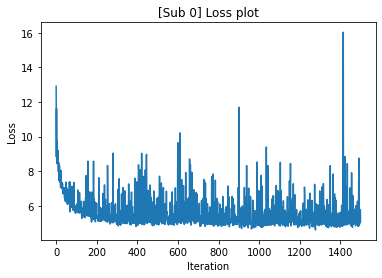

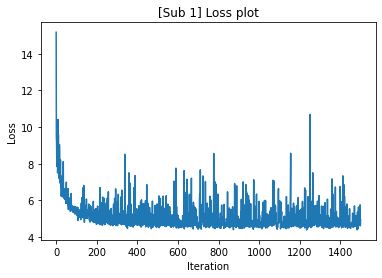

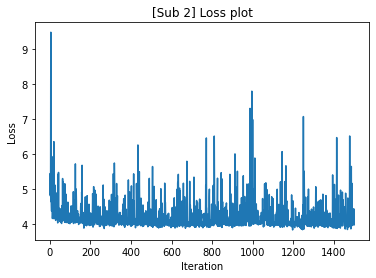

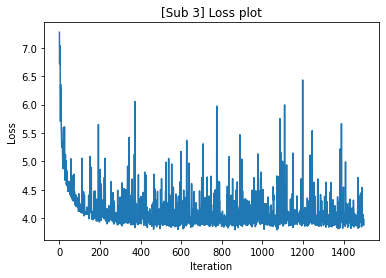

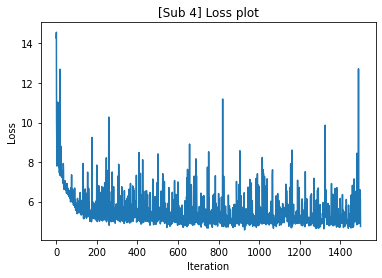

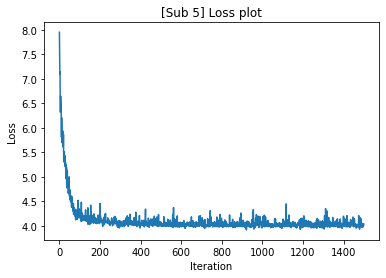

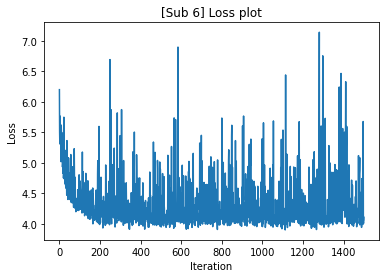

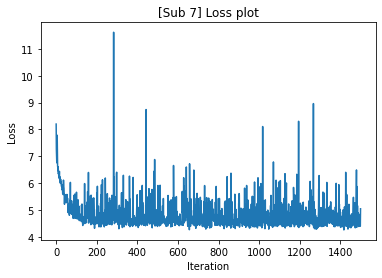

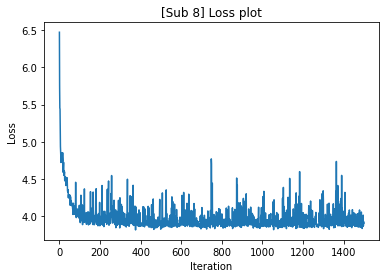

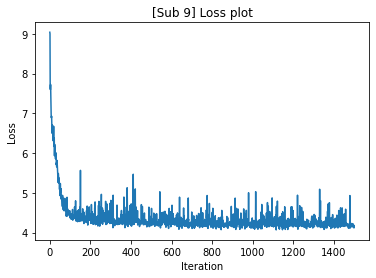

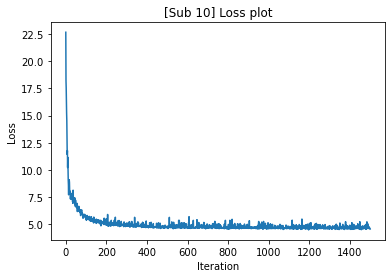

In [6]:
for i_sub in range(11):
    fig, ax = plt.subplots()
    
    ax.plot(loss_all[i_sub,:])
    ax.set_title('[Sub %d] Loss plot'%(i_sub))
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Loss')
    fig.savefig('./results/Bayesian/loss_plot_sub%d.png'%(i_sub))

## Extract extreme influence (small bp+small weight || large bp+large weight)

In [7]:
df = pd.DataFrame(data = {i : ['(,)' for j in range(21)] for i in range(11)})
bandName = ['t','a','b']

for i_sub in range(11):
    for i_channel in range(21):
        mean_w = torch.abs(torch.mean(weight_list[i_sub][channels[i_channel]], dim=0))
        max_bp, min_bp = torch.argmax(torch.abs(bp_ratio[i_sub,i_channel,:])), torch.argmin(torch.abs(bp_ratio[i_sub,i_channel,:]))
        max_w, min_w = torch.argmax(mean_w), torch.argmin(mean_w)
        
        if (max_bp == max_w):    # Strong influence
            cell = df.iloc[i_channel, i_sub]
            index_comma = cell.index(',')
            df.iloc[i_channel, i_sub] = cell[:index_comma] + bandName[max_bp.item()] + cell[index_comma:]
        
        if (min_bp == min_w):    # Slight influence
            cell = df.iloc[i_channel, i_sub]
            index_comma = cell.index(',')
            df.iloc[i_channel, i_sub] = cell[:index_comma+1] + bandName[min_bp.item()] + cell[index_comma+1:]
            
df = df.set_index(channels, drop=True)

In [8]:
df

0      1      2      3      4      5      6      7      8      9   \
Channel                                                                         
Fp1        (,)    (,)  (b,t)    (,)    (,)   (,t)  (a,t)    (,)   (,a)    (,)   
Fpz        (,)    (,)  (b,t)  (b,a)  (a,b)  (b,a)   (b,)    (,)    (,)   (b,)   
Fp2       (b,)   (b,)  (b,a)  (b,a)   (a,)  (b,a)   (,t)   (b,)    (,)    (,)   
F7         (,)  (b,t)   (,t)    (,)    (,)  (b,a)    (,)   (b,)    (,)  (b,t)   
F3         (,)   (,t)    (,)   (,a)  (a,b)  (b,a)    (,)    (,)    (,)    (,)   
Fz        (,t)  (b,a)   (,t)    (,)   (,b)    (,)   (a,)  (b,t)   (,a)    (,)   
F4        (,t)    (,)  (b,t)    (,)   (,b)  (b,a)   (,t)   (b,)   (,t)    (,)   
F8         (,)    (,)    (,)    (,)  (a,t)  (b,a)    (,)   (,t)    (,)    (,)   
T3         (,)  (b,t)    (,)    (,)  (b,t)   (,a)   (,t)  (b,t)    (,)    (,)   
C3        (a,)   (b,)  (b,t)   (,t)    (,)  (b,a)    (,)  (b,a)    (,)    (,)   
Cz         (,)   (a,)   (,a)   (,t)    (,)    (,)  (a,t)  (b,t)   (,a)   (,t)   
C4       (a,t)    (,)   (a,)    (,)    (,)   (b,)   (a,)  (b,t)    (,)  (b,t)   
T4         (,)   (,t)    (,)    (,)  (a,t)   (,a)    (,)   (,t)    (,)   (,t)   
T5        (,t)    (,)    (,)    (,)  (b,t)  (b,a)    (,)  (b,t)    (,)    (,)   
P3        (,t)   (,t)    (,)  (a,t)   (,t)    (,)   (,t)   (b,)  (a,t)    (,)   
Pz       (a,t)  (b,t)    (,)    (,)    (,)    (,)   (a,)  (b,a)   (a,)    (,)   
P4         (,)    (,)    (,)    (,)   (a,)   (b,)    (,)    (,)   (,t)  (b,t)   
T6       (a,t)    (,)    (,)   (,t)    (,)   (b,)   (a,)   (b,)  (b,t)   (b,)   
O1         (,)    (,)    (,)   (,t)   (,t)   (,a)  (a,t)   (,a)    (,)    (,)   
Oz        (a,)    (,)    (,)    (,)    (,)    (,)  (a,t)    (,)   (,t)   (,a)   
O2       (a,t)   (,t)    (,)    (,)   (,t)    (,)    (,)    (,)    (,)    (,)   

            10  
Channel         
Fp1      (b,a)  
Fpz      (b,t)  
Fp2       (,a)  
F7        (,a)  
F3        (b,)  
Fz         (,)  
F4         (,)  
F8        (,a)  
T3        (b,)  
C3         (,)  
Cz         (,)  
C4       (b,a)  
T4        (b,)  
T5        (b,)  
P3        (,t)  
Pz         (,)  
P4       (b,t)  
T6        (,t)  
O1         (,)  
Oz         (,)  
O2         (,)

## Linear Regression

[Sub 0] Std error: (12.09,13.67)
[Sub 1] Std error: (10.82,11.40)
[Sub 2] Std error: (6.17,5.80)
[Sub 3] Std error: (8.34,8.84)
[Sub 4] Std error: (12.46,14.27)
[Sub 5] Std error: (11.57,11.41)
[Sub 6] Std error: (7.96,7.93)
[Sub 7] Std error: (11.70,12.70)
[Sub 8] Std error: (10.32,10.37)
[Sub 9] Std error: (12.04,11.62)
[Sub 10] Std error: (14.69,15.29)


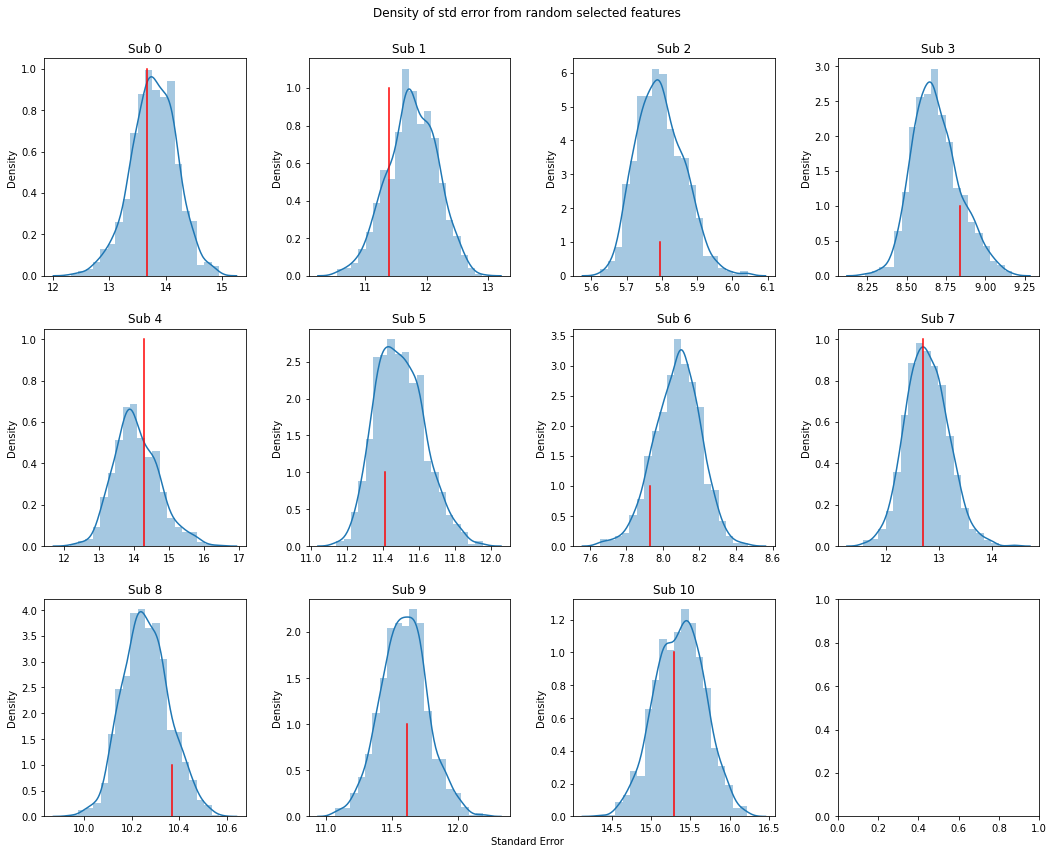

In [9]:
fig, axs = plt.subplots(3, 4, figsize=(15,12))

for i_sub in range(11):
    
    X_sub = dict_X[i_sub].numpy()
    Y_sub = dict_Y[i_sub].numpy()

    # Select features
    selected_features = []
    band_index = {'t':0, 'a':1, 'b':2}
    for i in range(21):
        cell = df[0][i]
        comma_index = cell.index(',')
        if cell[comma_index-1] in band_index:
            selected_features.append(i*3 + band_index[cell[comma_index-1]])

    std_all = {'train': [], 'test': []}
    for i_select in range(1001):
        if i_select != 0:    # First one is selected by Bayesian
            #print('random feature')
            selected_features = np.sort( np.random.choice(X_sub.shape[1], len(selected_features), replace=False) )
        X_sel = X_sub[:,selected_features]

        #print('Selected features: ', selected_features)

        kf = KFold(n_splits=10, shuffle=True, random_state=23)
        std_error = {'train':[], 'test':[]}
        for i_exp, (train_index, test_index) in enumerate(kf.split(X_sub)):
            train_data, test_data = X_sel[train_index,:], X_sel[test_index,:]
            train_target, test_target = Y_sub[train_index], Y_sub[test_index]

            rgr_model = Ridge()
            rgr_model.fit(train_data, train_target)
            train_pred = rgr_model.predict(train_data)
            test_pred = rgr_model.predict(test_data)

            std_error['train'].append(mean_squared_error(train_pred,train_target)**0.5)
            std_error['test'].append(mean_squared_error(test_pred,test_target)**0.5)

        [train_std, test_std] = [sum(std_error[x])/len(std_error[x]) for x in ['train','test']]
        std_all['train'].append(train_std)
        std_all['test'].append(test_std)

    print('[Sub %d] Std error: (%.2f,%.2f)'%(i_sub, std_all['train'][0], std_all['test'][0]))
    
    # Plot density plot of standard error
    row = i_sub//4
    col = i_sub%4
    
    sns.distplot(std_all['test'][1:], ax=axs[row,col], norm_hist=True, bins=20)
    axs[row,col].plot([std_all['test'][0]]*2, [0,1], 'r-')
    axs[row,col].set_title('Sub %d'%(i_sub))
    axs[row,col].set_ylabel('Density')
    
fig.text(0.5, 0.01, 'Standard Error', ha='center')
fig.suptitle('Density of std error from random selected features')
fig.tight_layout(pad=2.0)
fig.savefig('./results/Bayesian/density_SL_randomResult.png')